<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/4_InventoryDynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from numba import njit, int32

# **Solving the inventory model**

Given a demand $(D_{t})_{t\geq 0}$ and inventory $(X_{t})_{t\geq 0}$ process there's a **law of motion of invetory** described as

$$X_{t+1}=F(X_{t},A_{t},D_{t+1})$$

where $A_{t}$ is the stock ordered this period.

Particularly, the law of motion of invetories can be described as

$$F(X,A,D):=\max\left\{X-D,0\right\}+A$$

We assume that the firm can store at most $K$ items at one time, such that the **state space** is $X\in\left\{0,1,...,K\right\}$, and that $(D_{t})$ distributes as a random variable i.i.d. with distribution $\phi$.

**Profits** are given by

$$π_{t}=\min\left\{X_{t},D_{t+1}\right\}-cA_{t}-\kappa\left\{A_{t}>0\right\}$$

wich means that we assume that:


*   The price of each of the units of the invetory is equal to $1$.
*   The units of inventory sold are equal to $\min\left\{X_{t},D_{t+1}\right\}$.
*   There's a unit product cost denoted with $c$.
*    In case we order units of inventory, there's a fixed cost equal to $\kappa$.

Given all this assumptions, the **present value of the firm** is equal to

$$V_{0}=\mathbb{E}\sum_{t\geq 0}\beta^{t}π_{t}$$

Then, the **objective of the firm** is to maximize the present value of the firm.



The optimal present value of the firm can derive from the **value function** given by:

$$V(x_{t})=\max_\left\{a_{t+s}\in\Gamma(x_{t+s})\right\} E_{t} \sum_{s=0}^{\infty}\beta^{s}π(x_{t+s},a_{t+s},d_{t+1+s})$$

where $a_{t+s}\in\Gamma(x_{t+s})$ implies that the stock orders must be feasible (that is $\Gamma(x_{t+s})=\left\{0,1,...,K-x_{t+s}\right\}$) and $E_{t}$ is the expected value conditional to what happens in $t$.

This equation can be expressed as

$$V(x_{t})=\max_\left\{a_{t+s}\in\Gamma(x_{t+s})\right\} \left\{E_{t}\pi(x_{t},a_{t},d_{t+1})+E_{t}\sum_{s=1}^{\infty}\beta^{s}π(x_{t+s},a_{t+s},d_{t+1+s})\right\}$$

and by assuming $E_{t}\pi(x_{t},a_{t},d_{t+1})=r(x_{t},a_{t})$, we have that

$$V(x_{t})=\max_\left\{a_{t+s}\in\Gamma(x_{t+s})\right\} \left\{r(x_{t},a_{t})+E_{t}\sum_{s=1}^{\infty}\beta^{s}π(x_{t+s},a_{t+s},d_{t+1+s})\right\}$$

where $r(x_{t},a_{t})$ is the **expected current profit**.

We solve the inventory model **using the value function iterion (VFI) algorithm**.


We define a function that returns the index of the maximum element on a list

In [2]:
@njit # The function is compiled using numba's Just-In-Time compiler

def argmax(list_object):
  max_val = -np.inf    # Initialize the maximum value
  argmax_index = None  # Initialize the index of the maximum value
  for i, x in enumerate(list_object): # Initialize a loop for each pair (i,x) in enumerate(list_object)
    if x > max_val:      # If an (i,x) satisfies that x > max_ val, then: - max_val = x
      max_val = x        #                                                - arg_max = i
      argmax_index = i
  return argmax_index

We also use the succesive aproximation function, as defined on the previous notebook.

In [3]:
def succesive_approx(T,                # Operator
                     x_0,              # Initial condition
                     tol=1e-6,         # Error tolerance
                     max_iter=10_000,  # Maximum number of iteration
                     print_step=25,    # Frequency with which progress messages will be printed during iterations
                     verbose=False):   # Will not print progress messages during iterations

  x = x_0           # Initialize: - Initial condition
  error = tol + 1   #             - Error
  k = 1             #             - Number of iterations

  while error > tol and k <= max_iter:    # Initialize a bucle that keeps iterating while error > tol and k <= max_iter
    x_new = T(x)                          # Apply transformation
    error = np.max(np.abs(x_new - x))     # Gets the error with the supremum norm

    if verbose and k % print_step == 0:                      # If verbose=True and k is a multiple of print_step, progress message is printed
      print(f"Completed iteration {k} with error {error}.")

    x = x_new    # Update: - Initial condition
    k +=1        #         - Number of iterations

  if error > tol:
    print(f"Warning: Iteration hit upper bound {max_iter}.")
  elif verbose:
    print(f"Terminanted succesufully in {k} iterations.")

  return x

To store our model parameters, we use a namedtuple. Here we define the namedtuple and a function to create instances with default values.

In [4]:
Model = namedtuple('Model', ('beta',    # Discount factor
                             'kappa',   # Maximum inventory capacity
                             'c',       # Unit cost of stock
                             'K',       # Fixed cost of ordering stock
                             'p',       # Demand probability mass function parameter
                             'phi',     # Demanda probability mass function
                             'Gamma'))  # Feasible space for stock

def create_inventory_model(r=0.02,   # Interest rate
                           kappa=40, # Maximum inventory
                           c=0.2,    # Cost parameter
                           K=2,      # Cost parameter
                           p=0.6):   # Demand parameter

  # Define the discount factor
  beta = 1 / (1+r)

  # Define a geometric distribution on d = 0, 1, 2, ... with parameter p
  @njit
  def phi(d):
    return (1 - p) ** d * p

  # Define a feasible correspondence of space at the inventory
  @njit
  def Gamma(x):
    return range(kappa - x + 1)

  return Model(beta=beta, kappa=kappa, c=c, K=K, p=p, phi=phi, Gamma=Gamma)

The next function is the unmaximized RHS of the Bellman equation, which is:

$$B(x,a,v):=r(x,a)+\beta∑_{d}v[F(x,a,d)]\phi(d)=\text{profit}+\beta\cdot\text{continuation value}$$

In [5]:
@njit
def B(x, a, v, model, d_max=100):
  beta, kappa, c, K, p, phi, Gamma = model  # Unpacked model parameters

  expected_revenue   = sum([min(x,d) * phi(d) for d in range(d_max)])
  profit             = expected_revenue - c * a - K * (a > 0)
  continuation_value = sum([v[max(x - d, 0) + a] * phi(d) for d in range(d_max)])

  return profit + beta * continuation_value


Now we introduce the Bellman operator.

In [6]:
@njit
def T(v,model):
  beta, kappa, c, K, p, phi, Gamma = model
  new_v = np.empty_like(v)
  for x in range(kappa + 1):
    new_v[x] = max([B(x, a, v, model) for a in Gamma(x)])
  return new_v

Then we introduce a function that computes the $v$-greedy policy given $v$.

In [21]:
@njit
def get_greedy(v,model):
  beta, kappa, c, K, p, phi, Gamma = model
  sigma = np.empty_like(v, dtype=int32)
  for x in range(kappa + 1):
    sigma[x] = argmax([B(x, a, v, model) for a in Gamma(x)])
  return sigma

The function below applies VFI algorithm.

In [22]:
def vfi(v_init, model):
  v_star = succesive_approx(lambda v: T(v,model), v_init)
  sigma_star = get_greedy(v_star, model)
  return v_star, sigma_star

Now, let's test this functions.

In [23]:
model = create_inventory_model()
beta, kappa, c, K, p, phi, Gamma = model
v_init = np.zeros(kappa + 1)

In [24]:
v_star, sigma_star = vfi(v_init, model)

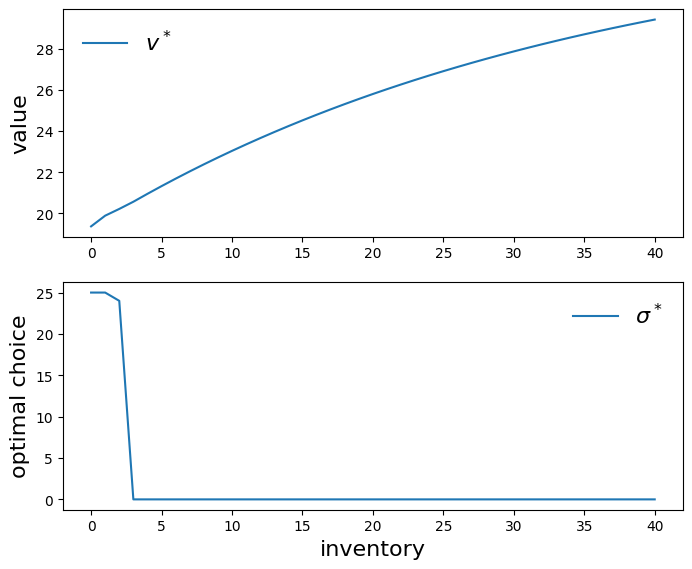

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))
fontsize=16

ax = axes[0]
ax.plot(range(kappa + 1), v_star, label="$v^*$")
ax.set_ylabel("value", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)

ax = axes[1]
ax.plot(range(kappa + 1), sigma_star, label="$\\sigma^*$")
ax.set_xlabel("inventory", fontsize=fontsize)
ax.set_ylabel("optimal choice", fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)
plt.show()